In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pickle
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
# Global setting
plt.style.use('seaborn')
file = "E:/telraam.csv"

C:\Users\DELL\AppData\Local\Temp\ipykernel_5040\1601746446.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [8]:
# Describe Data
def describeData(data):
    print("shape = {}".format(data.shape))
    description = data.describe().T
    description["isNull"] = data.isnull().sum()
    print(description)
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return math.sqrt(mean_squared_error(actual, predicted))

In [9]:
# Load the data
df = pd.read_csv(file, parse_dates = False, header = None,sep=',')
df.columns=['time','id','timezone','pct_up','pedestrian','bike','car','lorry','pedestrian_lft','bike_lft','car_lft','lorry_lft','pedestrian_rgt','bike_rgt','car_rgt','lorry_rgt','car_speed_00','car_speed_10','car_speed_20','car_speed_30','car_speed_40','car_speed_50','car_speed_60','car_speed_70']
df['time'] = pd.to_datetime(df['time'],errors='coerce',utc=True)  
df['time'] = df['time'].fillna(method = 'ffill')
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.head(5)
#describeData(df)

There are 971 rows and 24 columns


,time,id,timezone,pct_up,pedestrian,bike,car,lorry,pedestrian_lft,bike_lft,...,car_rgt,lorry_rgt,car_speed_00,car_speed_10,car_speed_20,car_speed_30,car_speed_40,car_speed_50,car_speed_60,car_speed_70
0,2020-06-11 16:00:00+00:00,9000000411,Europe/Paris,0.09,0.0,0.0,24.0,0.0,0.0,24.0,...,0.0,0.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-16 10:00:00+00:00,9000000411,Europe/Paris,0.10,21.0,63.0,682.0,0.0,0.0,388.0,...,294.0,0.0,210.0,242.0,158.0,53.0,11.0,11.0,NaN,NaN
2,2020-06-16 11:00:00+00:00,9000000411,Europe/Paris,0.76,19.0,56.0,747.0,0.0,12.0,392.0,...,355.0,0.0,131.0,230.0,266.0,92.0,11.0,4.0,4.0,12.0
3,2020-06-16 12:00:00+00:00,9000000411,Europe/Paris,0.63,22.0,45.0,539.0,0.0,11.0,159.0,...,380.0,0.0,171.0,92.0,168.0,68.0,15.0,13.0,8.0,8.0
4,2020-06-16 14:00:00+00:00,9000000411,Europe/Paris,0.42,36.0,125.0,820.0,0.0,12.0,553.0,...,267.0,0.0,322.0,365.0,102.0,15.0,8.0,5.0,3.0,5.0


In [10]:
# Skip the first row

minDate = '2020-06-16 00:00:00+00'
df = df.loc[df['time']>minDate]

# Reindex the data

df.set_index(['time'],drop=False,inplace=True)
all_freq = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(all_freq)
df['timezone'].fillna('Europe/Paris',inplace=True)
df['time'] = df.index
df['localtime']=df.time.map(lambda t: t.tz_convert(tz = 'Europe/Paris'))
df['dayofweek'] = df['localtime'].dt.dayofweek
df['day'] = df['localtime'].dt.day
df['hour'] = df['localtime'].dt.hour

In [11]:
df.head(5)

,time,id,timezone,pct_up,pedestrian,bike,car,lorry,pedestrian_lft,bike_lft,...,car_speed_20,car_speed_30,car_speed_40,car_speed_50,car_speed_60,car_speed_70,localtime,dayofweek,day,hour
2020-06-16 10:00:00+00:00,2020-06-16 10:00:00+00:00,9.000000e+09,Europe/Paris,0.10,21.0,63.0,682.0,0.0,0.0,388.0,...,158.0,53.0,11.0,11.0,NaN,NaN,2020-06-16 12:00:00+02:00,1,16,12
2020-06-16 11:00:00+00:00,2020-06-16 11:00:00+00:00,9.000000e+09,Europe/Paris,0.76,19.0,56.0,747.0,0.0,12.0,392.0,...,266.0,92.0,11.0,4.0,4.0,12.0,2020-06-16 13:00:00+02:00,1,16,13
2020-06-16 12:00:00+00:00,2020-06-16 12:00:00+00:00,9.000000e+09,Europe/Paris,0.63,22.0,45.0,539.0,0.0,11.0,159.0,...,168.0,68.0,15.0,13.0,8.0,8.0,2020-06-16 14:00:00+02:00,1,16,14
2020-06-16 13:00:00+00:00,2020-06-16 13:00:00+00:00,NaN,Europe/Paris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-16 15:00:00+02:00,1,16,15
2020-06-16 14:00:00+00:00,2020-06-16 14:00:00+00:00,9.000000e+09,Europe/Paris,0.42,36.0,125.0,820.0,0.0,12.0,553.0,...,102.0,15.0,8.0,5.0,3.0,5.0,2020-06-16 16:00:00+02:00,1,16,16


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1321 entries, 2020-06-16 10:00:00+00:00 to 2020-08-10 10:00:00+00:00
Freq: H
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype                       
---  ------          --------------  -----                       
 0   time            1321 non-null   datetime64[ns, UTC]         
 1   id              970 non-null    float64                     
 2   timezone        1321 non-null   object                      
 3   pct_up          970 non-null    float64                     
 4   pedestrian      970 non-null    float64                     
 5   bike            970 non-null    float64                     
 6   car             970 non-null    float64                     
 7   lorry           970 non-null    float64                     
 8   pedestrian_lft  970 non-null    float64                     
 9   bike_lft        970 non-null    float64                     
 10  car_lft         970 non-null    float64 

In [13]:
# Fill missing values
###########################################
for col in ['car','pedestrian','lorry','bike','pedestrian_lft','bike_lft','car_lft','lorry_lft','pedestrian_rgt','bike_rgt','car_rgt','lorry_rgt']:
    df['adjust_'+col] = df.groupby(['dayofweek','hour'])[col].transform(lambda x: x.fillna(x.median()))
    df[col].fillna(0,inplace=True)
df.fillna(0,inplace=True)
df.head(5)

,time,id,timezone,pct_up,pedestrian,bike,car,lorry,pedestrian_lft,bike_lft,...,adjust_lorry,adjust_bike,adjust_pedestrian_lft,adjust_bike_lft,adjust_car_lft,adjust_lorry_lft,adjust_pedestrian_rgt,adjust_bike_rgt,adjust_car_rgt,adjust_lorry_rgt
2020-06-16 10:00:00+00:00,2020-06-16 10:00:00+00:00,9.000000e+09,Europe/Paris,0.10,21.0,63.0,682.0,0.0,0.0,388.0,...,0.000000,63.000000,0.000000,388.000000,388.000000,0.00000,21.000000,42.000000,294.000000,0.000000
2020-06-16 11:00:00+00:00,2020-06-16 11:00:00+00:00,9.000000e+09,Europe/Paris,0.76,19.0,56.0,747.0,0.0,12.0,392.0,...,0.000000,56.000000,12.000000,392.000000,392.000000,0.00000,7.000000,36.000000,355.000000,0.000000
2020-06-16 12:00:00+00:00,2020-06-16 12:00:00+00:00,9.000000e+09,Europe/Paris,0.63,22.0,45.0,539.0,0.0,11.0,159.0,...,0.000000,45.000000,11.000000,159.000000,159.000000,0.00000,11.000000,25.000000,380.000000,0.000000
2020-06-16 13:00:00+00:00,2020-06-16 13:00:00+00:00,0.000000e+00,Europe/Paris,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,28.751856,59.840959,15.127145,319.632424,319.632424,2.97077,14.635468,29.030409,144.043481,25.431674
2020-06-16 14:00:00+00:00,2020-06-16 14:00:00+00:00,9.000000e+09,Europe/Paris,0.42,36.0,125.0,820.0,0.0,12.0,553.0,...,0.000000,125.000000,12.000000,553.000000,553.000000,0.00000,24.000000,61.000000,267.000000,0.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1321 entries, 2020-06-16 10:00:00+00:00 to 2020-08-10 10:00:00+00:00
Freq: H
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype                       
---  ------                 --------------  -----                       
 0   time                   1321 non-null   datetime64[ns, UTC]         
 1   id                     1321 non-null   float64                     
 2   timezone               1321 non-null   object                      
 3   pct_up                 1321 non-null   float64                     
 4   pedestrian             1321 non-null   float64                     
 5   bike                   1321 non-null   float64                     
 6   car                    1321 non-null   float64                     
 7   lorry                  1321 non-null   float64                     
 8   pedestrian_lft         1321 non-null   float64                     
 9   bike_lft               1321 n

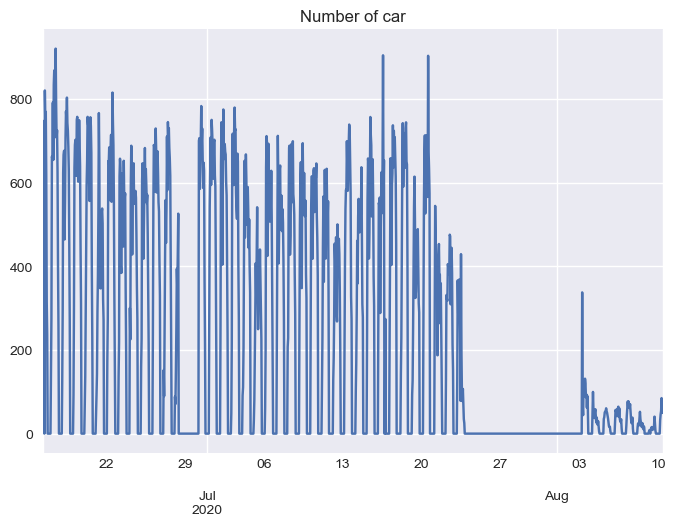

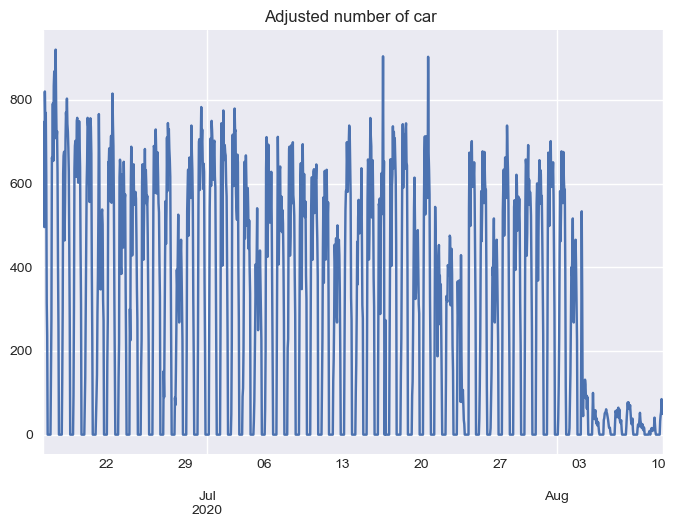

In [15]:
# See adjusted data versus row data
###########################################
df['car'].plot(title='Number of car')
plt.show()
df['adjust_car'].plot(title='Adjusted number of car ')
plt.show()

Decomposition with the function seasonal_decompose of statsmodels
This is a naive decomposition. It's just to illustrate the decomposition:

* a base level
* a trend
* a saisonality
* a noise

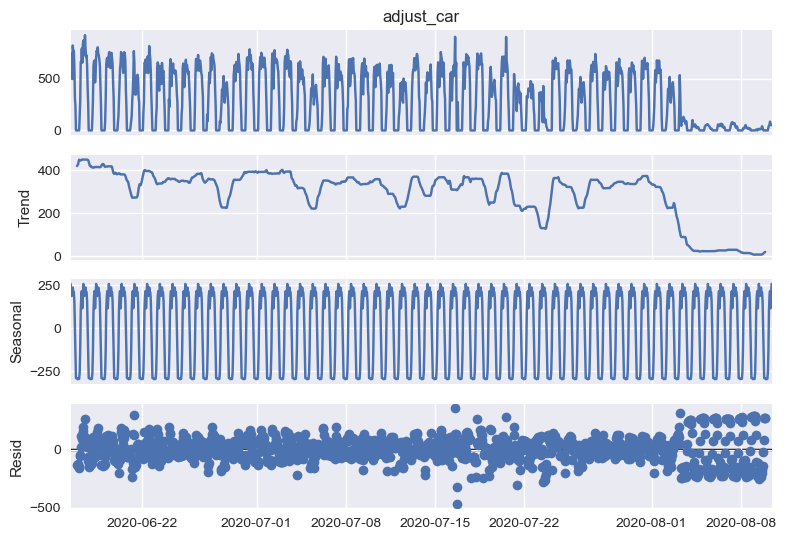

In [22]:
# Decomposition
###########################################
 
d=sm.tsa.seasonal_decompose(df.adjust_car,period=24)
figure = d.plot()
plt.show()

In [24]:
# Select a window of time with clean data 
###########################################

minDate = '2020-06-16 10:00:00+00'
maxDate = '2020-07-21 00:00:00+00'

# Select a window of time with clean data 
# AND
# Split train and test
###########################################
train = df.adjust_car.loc[df.index<'2020-07-19 00:00:00+00'].copy()
test = df.adjust_car.loc[(df.index>='2020-07-19 00:00:00+00')&(df.index<'2020-07-21 00:00:00+00')].copy().iloc[:48]
train_and_test = pd.concat([train,test])
print(train.shape)
print(test.shape)

(782,)
(48,)
